<center><h1> Neural Network using MINST Dataset </h1></center>

## Imports

In [7]:
# numpy provides arrays and useful functions for working with them
import numpy

# scipy.special for the sigmoid function expit()
import scipy

# For pickling the model and saving it to a file
import pickle

# For plotting the results
import matplotlib.pyplot as plt


## Constants

In [8]:
# number of input, hidden and output nodes
INPUT_NODES = 784
HIDDEN_NODES = 200
OUTPUT_NODES = 10

# learning rate
LEARNING_RATE = 0.01

## Training

### Creating the Neural Network

In [9]:
# neural network class definition
class neuralNetwork:
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc
        self.wih = numpy.random.normal(
            0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes)
        )
        self.who = numpy.random.normal(
            0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes)
        )

        # learning rate
        self.lr = learningrate

        # activation function is the sigmoid function
        # self.activation_function = lambda x: scipy.special.expit(x)
        self.activation_function = scipy.special.expit

        pass

    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)

        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot(
            (output_errors * final_outputs * (1.0 - final_outputs)),
            numpy.transpose(hidden_outputs),
        )

        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot(
            (hidden_errors * hidden_outputs * (1.0 - hidden_outputs)),
            numpy.transpose(inputs),
        )

        pass

    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        return final_outputs


In [10]:
# create instance of neural network
n = neuralNetwork(INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES, LEARNING_RATE)


### Loading the Training Dataset

In [11]:
# load the mnist training data CSV file into a list
training_data_file = open("dataset/mnist_train_100.csv", "r")
training_data_list = training_data_file.readlines()
training_data_file.close()


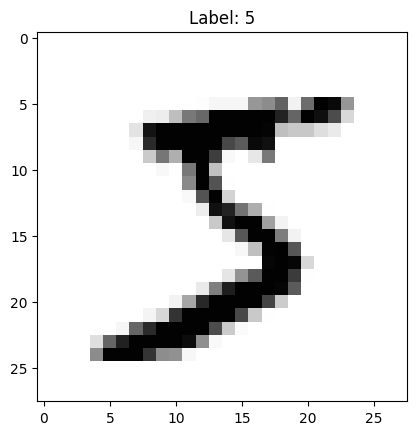

In [13]:
# split the first record by ',' to extract pixel values
all_values = training_data_list[0].split(",")
# convert the pixel values to a 28x28 numpy array with numeric type
image_array = numpy.asarray(all_values[1:], dtype=float).reshape((28, 28))

# plot the image
plt.imshow(image_array, cmap="Greys", interpolation="None")
plt.title(f"Label: {all_values[0]}")
plt.show()

### Training the Model

In [ ]:
# train the neural network

# epochs is the number of times the training data set is used for training
epochs = 10

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(",")
        # scale and shift the inputs
        inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = numpy.zeros(OUTPUT_NODES) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)

        ## create rotated variations
        # rotated anticlockwise by 10 degrees
        inputs_plus10_img = scipy.ndimage.rotate(
            inputs.reshape(28, 28), 10, cval=0.01, order=1, reshape=False
        )
        n.train(inputs_plus10_img.reshape(784), targets)
        # rotated clockwise by 10 degrees
        inputs_minus10_img = scipy.ndimage.rotate(
            inputs.reshape(28, 28), -10, cval=0.01, order=1, reshape=False
        )
        n.train(inputs_minus10_img.reshape(784), targets)

        pass
    pass


### Saving the Model

In [ ]:
with open("trained_model.pkl", "wb") as model_file:
    pickle.dump(n, model_file)

## Testing

### Loading the Test Dataset

In [ ]:
# load the mnist test data CSV file into a list
test_data_file = open("dataset/mnist_test_10.csv", "r")
test_data_list = test_data_file.readlines()
test_data_file.close()


### Testing the Model

In [ ]:
# test the neural network

# scorecard for how well the network performs, initially empty
scorecard = []

with open("trained_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

    # go through all the records in the test data set
    for record in test_data_list:
        # split the record by the ',' commas
        all_values = record.split(",")
        # correct answer is first value
        correct_label = int(all_values[0])
        # scale and shift the inputs
        inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
        # query the network
        outputs = loaded_model.query(inputs)
        # the index of the highest value corresponds to the label
        label = numpy.argmax(outputs)

        print(f"Label {label} (expected {correct_label})")
        # append correct or incorrect to list
        if label == correct_label:
            # network's answer matches correct answer, add 1 to scorecard
            scorecard.append(1)
        else:
            # network's answer doesn't match correct answer, add 0 to scorecard
            scorecard.append(0)
            pass

        pass


Label 7 (expected 7)
Label 0 (expected 2)
Label 1 (expected 1)
Label 0 (expected 0)
Label 4 (expected 4)
Label 1 (expected 1)
Label 4 (expected 4)
Label 4 (expected 9)
Label 4 (expected 5)
Label 7 (expected 9)


### Performance

In [ ]:
# calculate the performance score, the fraction of correct answers
scorecard_array = numpy.asarray(scorecard)
print("performance = ", scorecard_array.sum() / scorecard_array.size)


performance =  0.6
